In [2]:
import math
import numpy as np
%matplotlib inline
from graphviz import Digraph
import matplotlib.pyplot as plt

In [2]:
# Dummy function
def f(x):
    return 3*x**2 - 4*x + 5

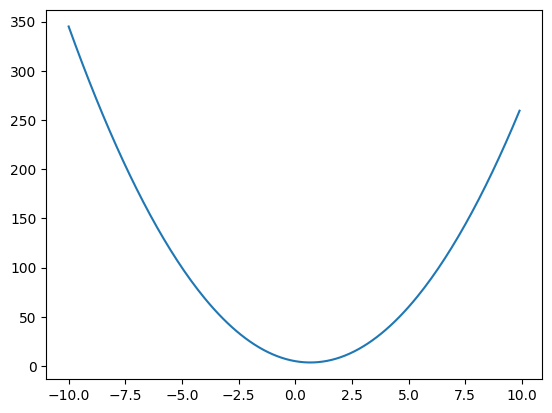

In [3]:
# Input vs output plot
x = np.arange(-10, 10, 0.1)
y = f(x)
plt.plot(x, y)

In [4]:
# Increasing slope
h = 0.000001
x = 3
(f(x + h) - f(x)) / h

14.000003002223593

In [5]:
# Decreasing slope
h = 0.000001
x = -3
(f(x + h) - f(x)) / h

-21.999997002808414

In [6]:
# Slope is near zero
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [7]:
# More complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a = a + h # taking a as variable -> b becomes slope
d2 = a*b + c
(d2 - d1) / h

-3.000000000064062

In [161]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # We using += because we might call backward multiple times and accumulate gradients
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # Example: 2 * a
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # Example: a / 2
        return self * (other**-1)
    
    def __neg__(self): # Example: -a
        return self * -1
    
    def __sub__(self, other): # Example: a - b
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo= []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo.reverse()
        self.grad = 1.0
        for node in topo:
            node._backward()

In [4]:
# For Visualization
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

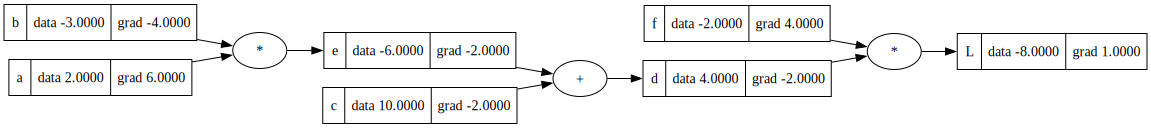

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
# a * b + c # (a.__mul__(b)).__add__(c)
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
# print(d) -> Value(data=4.0)
# print(d._prev) -> {Value(data=10.0), Value(data=-6.0)}
# print(d._op) -> '+'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

# Defining global gradients manually
dl = 1
L.grad = dl
dd = dl * f.data # As L = d * f
d.grad = dd
df = dl * d.data # As L = d * f
f.grad = df
de = dd * 1 # As d = e + c
e.grad = de
dc = dd * 1 # As d = e + c
c.grad = dc
da = de * b.data # As e = a * b
a.grad = da
db = de * a.data # As e = a * b
b.grad = db

draw_dot(L)

In [90]:
"""
GRADIENT ASCENT:-
To increase the value of L, we can nudge the valued of inputs a, b, c, f in the direction of their gradients.
The gradient tells us how much a small change in each input will affect the output L.
"""
def exampleGradientAscent():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    print('Before: ',L)

    a.data += h * da
    b.data += h * db
    c.data += h * dc
    f.data += h * df
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    L = d * f; L.label = 'L'
    print('After: ',L)

exampleGradientAscent()

Before:  Value(data=-8.0)
After:  Value(data=-7.992800640096002)


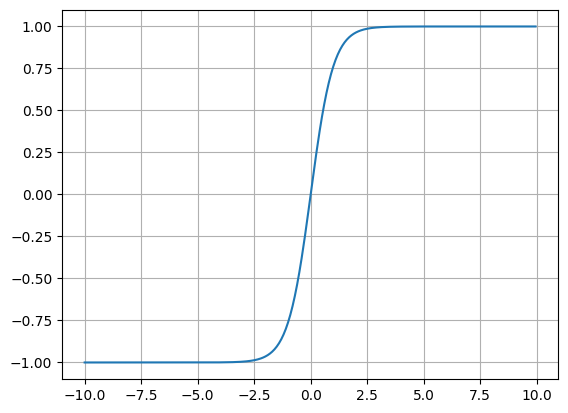

In [91]:
# Activation function example
plt.plot(np.arange(-10.0, 10.0, 0.05), np.tanh(np.arange(-10.0, 10.0, 0.05)))
plt.grid()

In [92]:
# Inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b') # approx -w1*2 + w2*0

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
# Defining global gradients manually
o.grad = 1.0
n.grad = 1 - o.data**2
b.grad = n.grad * 1
x1w1x2w2.grad = n.grad * 1
x2w2.grad = x1w1x2w2.grad * 1
x1w1.grad = x1w1x2w2.grad * 1
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [ ]:
# Using backward methods
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [93]:
# Using topological sort to call backward methods
# topo
"""
[Value(data=0.7071067811865476),
Value(data=0.8813735870195432),
Value(data=-6.0),
Value(data=-6.0),
Value(data=2.0),
Value(data=-3.0),
Value(data=0.0),
Value(data=0.0),
Value(data=1.0),
Value(data=6.881373587019543)]
"""
o.backward()

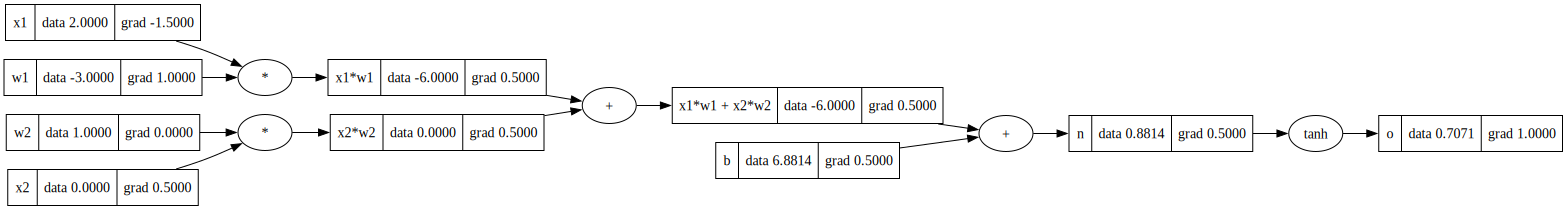

In [94]:
draw_dot(o)

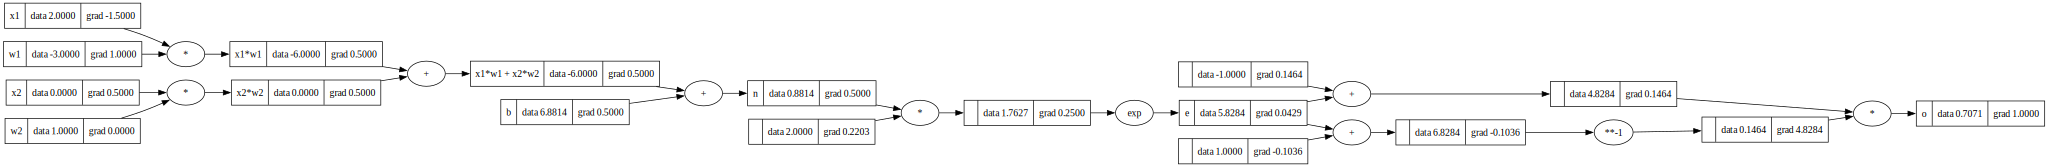

In [6]:
# Inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b') # approx -w1*2 + w2*0

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1); o.label = 'o'
o.backward()
draw_dot(o)

### Pytorch Implementation Example

In [13]:
import torch

In [14]:
# double() for 64 bit precision
# requires_grad = True for tracking all operations on the tensor
# data.item() to get the value of a tensor as a standard Python number instead of a tensor

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b; n.label = 'n'
o = torch.tanh(n); o.label = 'o'
print(o.item()) # item() and data.item() are same
print()
o.backward()

print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7071066904050358

-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


In [242]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.randn()) for _ in range(nin)]
        self.b = Value(0.0)
    
    def __call__(self, x):
        # b + w1*x1 + w2*x2 + ... using sum() function and zip()
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0, 0.5]
# n = Neuron(4)
# n = Layer(4, 3)
n = MLP(4, [4, 4, 1])
n(x)

Value(data=-0.12065642836857692)

In [270]:
xs = [
    [2.0, 3.0, -1.0, 0.5],
    [3.0, -1.0, 0.5, 2.0],
    [4.0, 0.5, 2.0, 3.0],
    [0.5, 2.0, 3.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # target values

In [ ]:
for k in range(20): # epochs
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for yout, ygt in zip(ypred, ys)), Value(0.0))
    # backward pass
    loss.backward()
    # update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad # gradient descent
        p.grad = 0.0 # reset to zero for next iteration so that gradients don't accumulate
    print(k, loss.data)

0 0.02049647075244213
1 0.00011012882615350439
2 0.0007352660100112494
3 0.0015285324416242946
4 0.0017514700400739654
5 0.002874447581475349
6 0.005008778109630279
7 0.008283428489350628
8 0.009690441602793157
9 0.006035249517483892
10 0.002171945785894119
11 0.0005715080844554244
12 0.00012582996210638462
13 2.438186169087049e-05
14 4.231898308278568e-06
15 6.632744855099127e-07
16 9.441784222226814e-08
17 1.22738712262903e-08
18 1.4651918862791107e-09
19 1.6154963548215304e-10


In [271]:
ypred

[Value(data=1.0),
 Value(data=-0.9999920449519231),
 Value(data=-0.9999900870364887),
 Value(data=1.0)]

In [272]:
n.parameters()

[Value(data=1.6252931876022763),
 Value(data=-0.6033077720099596),
 Value(data=-0.2799975605064179),
 Value(data=1.1862866522148614),
 Value(data=0.0),
 Value(data=-1.1727763174060029),
 Value(data=1.2821426570757994),
 Value(data=-0.8465686269518544),
 Value(data=0.14459435988792627),
 Value(data=0.0),
 Value(data=-1.3675905518296043),
 Value(data=-0.609340308564385),
 Value(data=0.011761702852529103),
 Value(data=-0.7414072384792721),
 Value(data=0.0),
 Value(data=0.17425189780529998),
 Value(data=-0.2253027608063224),
 Value(data=0.12332075005387357),
 Value(data=0.866121381362967),
 Value(data=0.0),
 Value(data=0.11654266657222033),
 Value(data=0.9023227666705901),
 Value(data=1.8376766289531536),
 Value(data=0.2677205653857357),
 Value(data=0.0),
 Value(data=-0.988435862525915),
 Value(data=-0.9719443920464113),
 Value(data=-1.3482923396550126),
 Value(data=1.3285782898136178),
 Value(data=0.0),
 Value(data=-0.981227795323835),
 Value(data=1.7401421047621175),
 Value(data=0.282012